# 🎓 Week 11 - Day 3: Semantic Segmentation with UNET

## Today's Goals:
✅ Understand semantic segmentation  
✅ Learn UNET architecture (encoder-decoder + skip connections)  
✅ Use segmentation_models_pytorch library  
✅ Create pixel-level segmentation masks  

---

## 📦 Part 1: Setup & Understanding Segmentation

Let's install the library and understand what segmentation masks look like!

In [1]:
# Install segmentation_models_pytorch
!pip install segmentation-models-pytorch -q
!pip install albumentations -q

print("✅ Libraries installed!")

✅ Libraries installed!


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Zigron\\anaconda3\\envs\\ai_bootcamp\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
# Import libraries
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import cv2
import warnings
warnings.filterwarnings('ignore')

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
print(f"✅ segmentation_models_pytorch version: {smp.__version__}")

✅ Using device: cpu
✅ segmentation_models_pytorch version: 0.5.0


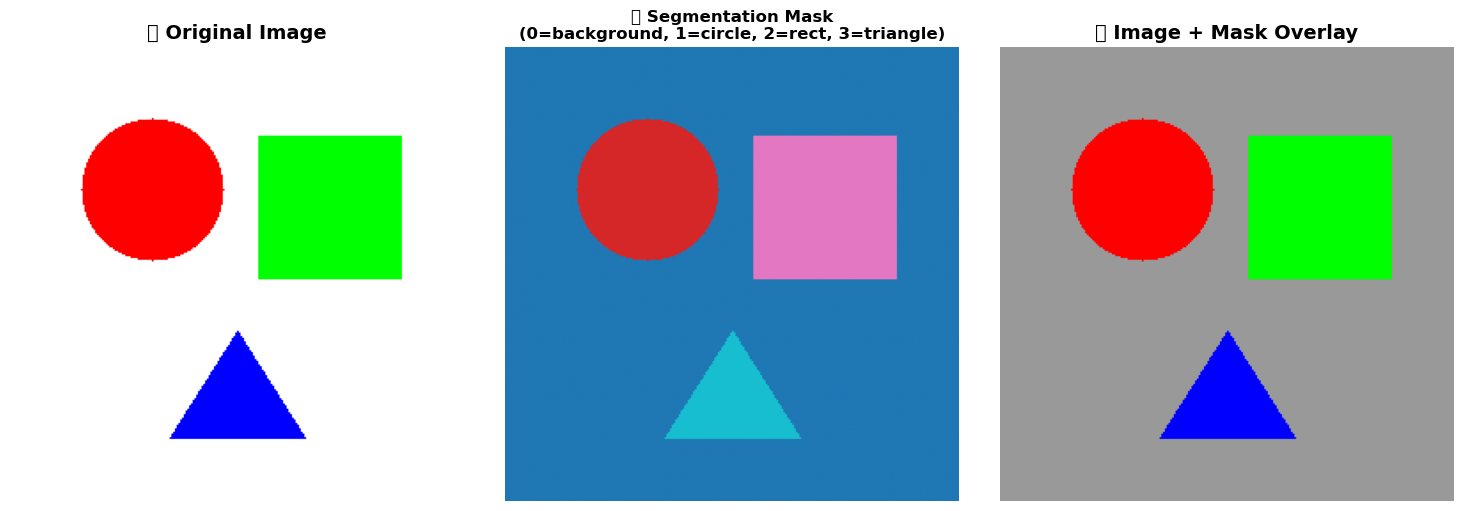


💡 Segmentation assigns a class to EVERY pixel!
   • Mask shape: (256, 256)
   • Unique classes: [0 1 2 3] (0=background, 1,2,3=objects)


In [3]:
# Create a simple example to understand segmentation
# Let's create a synthetic image with geometric shapes

# Create blank image (white background)
img = np.ones((256, 256, 3), dtype=np.uint8) * 255

# Draw a blue circle
cv2.circle(img, (80, 80), 40, (255, 0, 0), -1)

# Draw a green rectangle
cv2.rectangle(img, (140, 50), (220, 130), (0, 255, 0), -1)

# Draw a red triangle
pts = np.array([[128, 160], [90, 220], [166, 220]], np.int32)
cv2.fillPoly(img, [pts], (0, 0, 255))

# Create corresponding segmentation mask
mask = np.zeros((256, 256), dtype=np.uint8)

# Circle = class 1
cv2.circle(mask, (80, 80), 40, 1, -1)

# Rectangle = class 2
cv2.rectangle(mask, (140, 50), (220, 130), 2, -1)

# Triangle = class 3
cv2.fillPoly(mask, [pts], 3)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title('📸 Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mask, cmap='tab10')
axes[1].set_title('🎨 Segmentation Mask\n(0=background, 1=circle, 2=rect, 3=triangle)', 
                  fontsize=12, fontweight='bold')
axes[1].axis('off')

# Overlay
overlay = img.copy()
colored_mask = np.zeros_like(img)
colored_mask[mask == 1] = [255, 0, 0]  # Circle - Blue
colored_mask[mask == 2] = [0, 255, 0]  # Rectangle - Green
colored_mask[mask == 3] = [0, 0, 255]  # Triangle - Red
overlay = cv2.addWeighted(overlay, 0.6, colored_mask, 0.4, 0)

axes[2].imshow(overlay)
axes[2].set_title('🎯 Image + Mask Overlay', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Segmentation assigns a class to EVERY pixel!")
print(f"   • Mask shape: {mask.shape}")
print(f"   • Unique classes: {np.unique(mask)} (0=background, 1,2,3=objects)")

### 💡 Understanding Segmentation:

✅ **Image** - RGB pixels (256×256×3)  
✅ **Mask** - Class labels per pixel (256×256×1)  
✅ **Classes** - 0=background, 1,2,3=different objects  
✅ **Overlay** - Visual combination to verify correctness  

**Key Difference from Detection:**
- Detection: Bounding boxes (rectangles)
- Segmentation: Exact pixel-level boundaries

---

## 🏗️ Part 2: Loading Pre-trained UNET

Let's use segmentation_models_pytorch to load a UNET with pre-trained weights!

In [4]:
# List available architectures
print("📋 Available Segmentation Architectures:")
architectures = ['Unet', 'UnetPlusPlus', 'MAnet', 'Linknet', 'FPN', 
                'PSPNet', 'DeepLabV3', 'DeepLabV3Plus', 'PAN']
for i, arch in enumerate(architectures, 1):
    print(f"   {i}. {arch}")

print("\n📋 Available Encoder Backbones (partial list):")
backbones = ['resnet18', 'resnet34', 'resnet50', 'vgg16', 'vgg19', 
            'efficientnet-b0', 'mobilenet_v2']
for i, bb in enumerate(backbones, 1):
    print(f"   {i}. {bb}")

print("\n💡 We'll use UNET with ResNet34 backbone!")

📋 Available Segmentation Architectures:
   1. Unet
   2. UnetPlusPlus
   3. MAnet
   4. Linknet
   5. FPN
   6. PSPNet
   7. DeepLabV3
   8. DeepLabV3Plus
   9. PAN

📋 Available Encoder Backbones (partial list):
   1. resnet18
   2. resnet34
   3. resnet50
   4. vgg16
   5. vgg19
   6. efficientnet-b0
   7. mobilenet_v2

💡 We'll use UNET with ResNet34 backbone!


In [5]:
# Create UNET model (just 2 lines!)
print("🏗️ Creating UNET model...")

model = smp.Unet(
    encoder_name="resnet34",        # Encoder backbone
    encoder_weights="imagenet",     # Pre-trained on ImageNet
    in_channels=3,                  # RGB input
    classes=4,                      # Number of output classes (0-3)
)

model = model.to(device)

print("✅ UNET model created!")
print(f"\n📊 Model Details:")
print(f"   • Architecture: UNET")
print(f"   • Encoder: ResNet34 (pre-trained on ImageNet)")
print(f"   • Input: 3 channels (RGB)")
print(f"   • Output: 4 classes")
print(f"   • Parameters: {sum(p.numel() for p in model.parameters()):,}")

🏗️ Creating UNET model...


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✅ UNET model created!

📊 Model Details:
   • Architecture: UNET
   • Encoder: ResNet34 (pre-trained on ImageNet)
   • Input: 3 channels (RGB)
   • Output: 4 classes
   • Parameters: 24,436,804


In [6]:
# Test model with dummy input
print("🧪 Testing model with dummy input...")

# Create random input (batch_size=1, channels=3, height=256, width=256)
dummy_input = torch.randn(1, 3, 256, 256).to(device)

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

print(f"✅ Model test successful!")
print(f"\n📊 Input/Output Shapes:")
print(f"   • Input:  {dummy_input.shape} (batch, channels, height, width)")
print(f"   • Output: {output.shape} (batch, classes, height, width)")
print(f"\n💡 Output has 4 channels (one per class)!")

🧪 Testing model with dummy input...
✅ Model test successful!

📊 Input/Output Shapes:
   • Input:  torch.Size([1, 3, 256, 256]) (batch, channels, height, width)
   • Output: torch.Size([1, 4, 256, 256]) (batch, classes, height, width)

💡 Output has 4 channels (one per class)!


### 💡 UNET Architecture Insights:

✅ **Encoder (ResNet34)** - Pre-trained on ImageNet (feature extraction)  
✅ **Decoder** - Upsamples to original resolution  
✅ **Skip Connections** - Preserve spatial details  
✅ **Output** - 4 channels (one per class, pixel-wise predictions)  

**How it works:**
1. Image → Encoder → Extract features (downsampling)
2. Bottleneck → Deepest representation
3. Decoder → Upsample back to original size
4. Skip connections → Add fine details from encoder
5. Output → 4 class probability maps

---

## 🎨 Part 3: Simple Prediction Demo

Let's use our synthetic shapes example to see how UNET predicts!

In [7]:
# Prepare our synthetic image for model
# Model expects: (batch, channels, height, width) and normalized

# Convert to tensor and normalize
img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
img_tensor = img_tensor.to(device)

print(f"📊 Input tensor shape: {img_tensor.shape}")

# Make prediction
model.eval()
with torch.no_grad():
    pred = model(img_tensor)

print(f"📊 Prediction shape: {pred.shape}")
print("\n💡 Note: Model is untrained, so predictions will be random!")
print("💡 After training, it would learn to predict correct masks.")

📊 Input tensor shape: torch.Size([1, 3, 256, 256])
📊 Prediction shape: torch.Size([1, 4, 256, 256])

💡 Note: Model is untrained, so predictions will be random!
💡 After training, it would learn to predict correct masks.


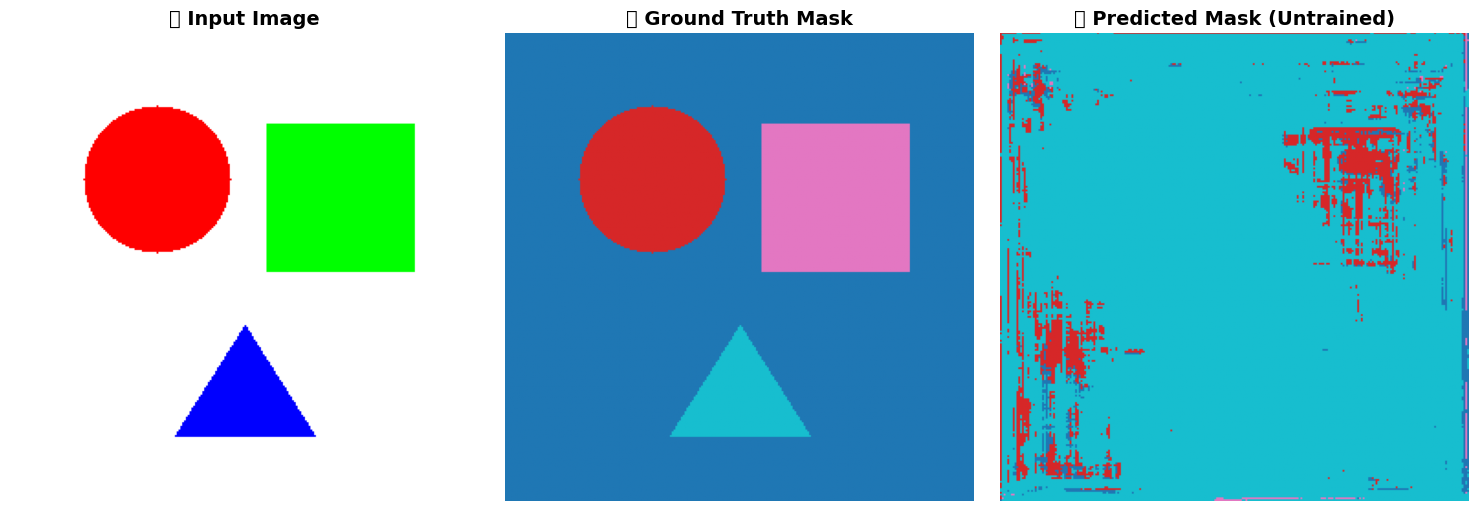


💡 Prediction is random because model is untrained!
💡 After training on labeled data, predictions would match ground truth.


In [8]:
# Convert prediction to class labels
pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title('📸 Input Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mask, cmap='tab10')
axes[1].set_title('✅ Ground Truth Mask', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='tab10')
axes[2].set_title('🎲 Predicted Mask (Untrained)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Prediction is random because model is untrained!")
print("💡 After training on labeled data, predictions would match ground truth.")

### 💡 Prediction Process:

✅ **Input preprocessing** - Normalize, convert to tensor, add batch dim  
✅ **Forward pass** - Model outputs 4 channels (class probabilities)  
✅ **Argmax** - Select class with highest probability per pixel  
✅ **Result** - Segmentation mask (same size as input)  

**Note:** This model is untrained on our specific task, so predictions are random. With training on labeled segmentation datasets, it would learn to produce accurate masks!

---

## 📊 Part 4: Segmentation Metrics

Let's understand how to evaluate segmentation quality!

In [9]:
# IoU (Intersection over Union) calculation
def calculate_iou(pred_mask, true_mask, num_classes):
    """
    Calculate IoU for each class
    IoU = Intersection / Union
    """
    ious = []
    
    for cls in range(num_classes):
        # Pixels belonging to class cls
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        
        # Intersection: pixels correctly predicted as class cls
        intersection = np.logical_and(pred_cls, true_cls).sum()
        
        # Union: all pixels predicted or actually belonging to class cls
        union = np.logical_or(pred_cls, true_cls).sum()
        
        if union == 0:
            iou = 0.0
        else:
            iou = intersection / union
        
        ious.append(iou)
    
    return ious

# Calculate IoU for our example
ious = calculate_iou(pred_mask, mask, num_classes=4)

print("📊 IoU Scores per Class:\n")
class_names = ['Background', 'Circle', 'Rectangle', 'Triangle']
for i, (name, iou) in enumerate(zip(class_names, ious)):
    print(f"   Class {i} ({name}): {iou:.4f}")

mean_iou = np.mean(ious)
print(f"\n📊 Mean IoU: {mean_iou:.4f}")
print("\n💡 IoU ranges from 0.0 (no overlap) to 1.0 (perfect match)")
print("💡 Good segmentation typically has IoU > 0.7")

📊 IoU Scores per Class:

   Class 0 (Background): 0.0299
   Class 1 (Circle): 0.0000
   Class 2 (Rectangle): 0.0006
   Class 3 (Triangle): 0.0405

📊 Mean IoU: 0.0177

💡 IoU ranges from 0.0 (no overlap) to 1.0 (perfect match)
💡 Good segmentation typically has IoU > 0.7


In [10]:
# Dice Score calculation
def calculate_dice(pred_mask, true_mask, num_classes):
    """
    Calculate Dice Score for each class
    Dice = 2 * Intersection / (Pred + True)
    """
    dice_scores = []
    
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        
        intersection = np.logical_and(pred_cls, true_cls).sum()
        pred_sum = pred_cls.sum()
        true_sum = true_cls.sum()
        
        if (pred_sum + true_sum) == 0:
            dice = 0.0
        else:
            dice = 2 * intersection / (pred_sum + true_sum)
        
        dice_scores.append(dice)
    
    return dice_scores

# Calculate Dice scores
dice_scores = calculate_dice(pred_mask, mask, num_classes=4)

print("🎲 Dice Scores per Class:\n")
for i, (name, dice) in enumerate(zip(class_names, dice_scores)):
    print(f"   Class {i} ({name}): {dice:.4f}")

mean_dice = np.mean(dice_scores)
print(f"\n🎲 Mean Dice Score: {mean_dice:.4f}")
print("\n💡 Dice Score is similar to IoU but more sensitive to small objects")
print("💡 Commonly used in medical image segmentation")

🎲 Dice Scores per Class:

   Class 0 (Background): 0.0581
   Class 1 (Circle): 0.0000
   Class 2 (Rectangle): 0.0012
   Class 3 (Triangle): 0.0778

🎲 Mean Dice Score: 0.0343

💡 Dice Score is similar to IoU but more sensitive to small objects
💡 Commonly used in medical image segmentation


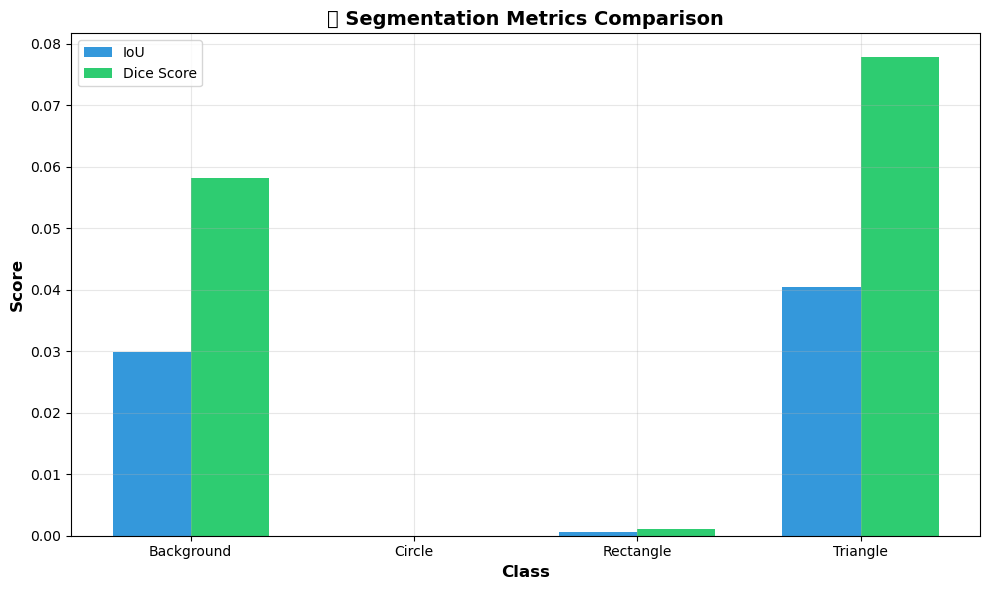


✅ Both metrics measure overlap between prediction and ground truth
✅ Higher is better (max = 1.0)


In [11]:
# Visualize metrics comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_names))
width = 0.35

ax.bar(x - width/2, ious, width, label='IoU', color='#3498db')
ax.bar(x + width/2, dice_scores, width, label='Dice Score', color='#2ecc71')

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('📊 Segmentation Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Both metrics measure overlap between prediction and ground truth")
print("✅ Higher is better (max = 1.0)")

### 💡 Metrics Explained:

**IoU (Intersection over Union):**
- Formula: `Intersection / Union`
- Measures overlap between prediction and ground truth
- Range: 0.0 to 1.0
- Standard metric for segmentation

**Dice Score:**
- Formula: `2 * Intersection / (Pred + True)`
- Similar to IoU but weights differently
- More sensitive to small objects
- Preferred in medical imaging

**When to use:**
- IoU: General segmentation tasks
- Dice: Medical imaging, small objects
- Often report both for completeness!

---

## 🎯 Part 5: Mini Challenge

Now it's your turn to experiment!

### 🏆 Challenge Tasks:

**Your Mission:**
1. Create a different synthetic image (different shapes/colors)
2. Create the corresponding ground truth mask
3. Try a different UNET backbone (e.g., ResNet50, VGG16)
4. Calculate IoU and Dice scores

**Hints:**
```python
# Try different backbone
model = smp.Unet(
    encoder_name="resnet50",  # or "vgg16", "efficientnet-b0"
    encoder_weights="imagenet",
    in_channels=3,
    classes=4,
)

# Try different architecture
model = smp.UnetPlusPlus(  # or FPN, DeepLabV3Plus
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=4,
)

# Draw different shapes
cv2.circle(img, center, radius, color, -1)
cv2.rectangle(img, pt1, pt2, color, -1)
cv2.ellipse(img, center, axes, angle, 0, 360, color, -1)
```

**Expected Outcome:**
- Create custom segmentation example
- Compare different model architectures
- Understand how encoder choice affects parameters

**Bonus Challenges:**
- Count parameters for different backbones
- Visualize which backbone is faster
- Create a 3-class problem instead of 4-class

In [12]:
# Your code here!
# Try the challenges above



---

## 📚 Summary

### What We Learned:

**1. Semantic Segmentation Basics:**
- Pixel-level classification
- Every pixel gets a class label
- Output is a mask (same size as input)
- Applications: Medical, autonomous driving, satellite imagery

**2. UNET Architecture:**
- Encoder-decoder structure
- Encoder: Downsample, extract features
- Decoder: Upsample, reconstruct spatial dimensions
- Skip connections: Preserve fine details
- U-shaped architecture (hence "UNET")

**3. segmentation_models_pytorch:**
- Easy-to-use library
- Multiple architectures (UNET, FPN, DeepLabV3+, etc.)
- Various encoder backbones (ResNet, VGG, EfficientNet)
- Pre-trained weights on ImageNet
- 2-3 lines to create model!

**4. Evaluation Metrics:**
- IoU (Intersection over Union): Standard metric
- Dice Score: Sensitive to small objects
- Both range 0.0 to 1.0 (higher is better)
- Good segmentation: IoU/Dice > 0.7

### 🎯 Key Takeaways:

✅ Segmentation provides pixel-perfect object boundaries  
✅ UNET's skip connections are crucial for detail preservation  
✅ Pre-trained encoders give huge head start  
✅ segmentation_models_pytorch makes implementation trivial  
✅ IoU and Dice are standard evaluation metrics  

### 💡 Pro Tips:

- **Start with UNET + ResNet34** - good balance of speed and accuracy
- **Use pre-trained encoders** - always better than random init
- **Monitor both IoU and Dice** - they highlight different aspects
- **Augmentation is crucial** - especially for small datasets
- **Class imbalance matters** - background often dominates

### 🏗️ Architecture Comparison:

| Architecture | Speed | Accuracy | Best For |
|-------------|-------|----------|----------|
| UNET | ⚡⚡ | ⭐⭐⭐ | Medical, general purpose |
| UNET++ | ⚡ | ⭐⭐⭐⭐ | Better feature fusion |
| FPN | ⚡⚡⚡ | ⭐⭐⭐ | Multi-scale objects |
| DeepLabV3+ | ⚡ | ⭐⭐⭐⭐⭐ | State-of-the-art |
| PSPNet | ⚡ | ⭐⭐⭐⭐ | Scene parsing |

### 🎓 Real-World Training Workflow:

```python
# 1. Load model with pre-trained encoder
model = smp.Unet('resnet34', encoder_weights='imagenet', classes=n)

# 2. Prepare dataset (images + masks)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 3. Define loss (CrossEntropy or Dice Loss)
criterion = nn.CrossEntropyLoss()

# 4. Train (5-10 epochs often sufficient)
for epoch in range(epochs):
    for images, masks in train_loader:
        outputs = model(images)
        loss = criterion(outputs, masks)
        # backward pass...

# 5. Evaluate on validation set
iou = calculate_iou(predictions, ground_truth)
```

---

### 🚀 Next Steps:

**This week you learned:**
- Day 1: Transfer Learning - Reuse pre-trained models
- Day 2: YOLO Detection - Find objects with bounding boxes
- Day 3: UNET Segmentation - Pixel-perfect boundaries

**You now have the tools to:**
- Fine-tune models on custom datasets
- Detect objects in real-time
- Segment images at pixel level

**Project Idea:** Combine all three!
1. Transfer learning for custom object recognition
2. YOLO for object detection
3. UNET for precise segmentation

**Great job completing Week 11! 🎉**

You've mastered three powerful computer vision techniques that are used in production systems worldwide!